# FRK v2-style surrogate (Python analog) for Marrel et al. (2010) Campbell2D

This notebook mirrors `01_run_pipeline.ipynb` but replaces the wavelet decomposition with
a **fixed-rank basis expansion** and a **sparse precision penalty** (FRK v2 idea).

We implement:
- Multi-resolution compactly supported bisquare basis (Fixed Rank component)
- Block-diagonal graph-Laplacian penalty over knot centers (sparse precision idea)
- Per-run penalized projection to obtain coefficients eta
- GP/linear/mean emulation of coefficients as in Marrel Method 3 (k*=30, k′=500)
- Nested-MC Sobol map estimation from the metamodel


In [1]:
# Bootstrap imports
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "marrel_pipeline").exists():
    PROJECT_ROOT = PROJECT_ROOT.parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import matplotlib.pyplot as plt

from marrel_pipeline.config import DEFAULTS
from marrel_pipeline.campbell2d import make_spatial_grid, campbell2d_map
from marrel_pipeline.pipeline import (
    build_training_data,
    frk_decompose_training_maps,
    order_coefficients_by_variance,
    fit_frk_functional_metamodel,
)
from marrel_pipeline.functional_frk_metamodel import predict_map_from_frk_models
from marrel_pipeline.diagnostics import mse_q2, rmae
from marrel_pipeline.sobol_exact import saltelli_exact_sobol_maps
from marrel_pipeline.sobol_metamodel import nested_mc_sobol_maps
from marrel_pipeline.plotting import plot_map, plot_index_grid


## Parameters

In [2]:
cfg = DEFAULTS

FAST = True
if FAST:
    cfg = type(cfg)(**{**cfg.__dict__,
        "saltelli_N_exact": 20_000,
        "mc_outer_first": 80,
        "mc_inner_first": 200,
        "mc_outer_total": 80,
        "mc_inner_total": 200,
        "mc_varY": 4000
    })

print(cfg)


MarrelConfig(d=8, x_low=-1.0, x_high=5.0, grid_n1=64, grid_n2=64, z_low=-90.0, z_high=90.0, n_train=200, K=4096, k_gp=30, k_lin=500, saltelli_N_exact=20000, mc_outer_first=80, mc_inner_first=200, mc_outer_total=80, mc_inner_total=200, mc_varY=4000, wavelet='db4', wavelet_level=6, frk_levels=3, frk_knots_per_level=(10, 15, 20), frk_radius_factor=2.5, frk_lambda_pen=0.01, frk_add_intercept=False)


## Training data

In [3]:
Z1, Z2 = make_spatial_grid(cfg.grid_n1, cfg.grid_n2, cfg.z_low, cfg.z_high)
X_train, Y_train = build_training_data(n=cfg.n_train, d=cfg.d, low=cfg.x_low, high=cfg.x_high, Z1=Z1, Z2=Z2, seed=12345)
X_train.shape, Y_train.shape


((200, 8), (200, 64, 64))

## FRK decomposition: basis projection to coefficients

In [4]:
mu_map, eta, basis = frk_decompose_training_maps(
    Y_train, Z1, Z2,
    levels=cfg.frk_levels,
    knots_per_level=cfg.frk_knots_per_level,
    radius_factor=cfg.frk_radius_factor,
    lambda_pen=cfg.frk_lambda_pen,
    add_intercept=cfg.frk_add_intercept
)

print("eta shape:", eta.shape, "basis r:", basis.B.shape[1])


eta shape: (200, 725) basis r: 725


## Order coefficients by variance and fit coefficient models (Method 3)

In [5]:
eta_sorted, order, inv_order, var_sorted = order_coefficients_by_variance(eta)
k_lin = min(cfg.k_lin, eta_sorted.shape[1] - cfg.k_gp)
models = fit_frk_functional_metamodel(X_train, eta_sorted, k_gp=cfg.k_gp, k_lin=k_lin, seed=0)
len(models), models[0].kind, models[cfg.k_gp].kind


/opt/miniconda3/envs/qualifying_exam/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qualifying_exam/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qualifying_exam/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/minicon

(725, 'gp', 'lin')

## Diagnostics: predictivity on 1000-map test set

In [6]:
rng = np.random.default_rng(999)
X_test = cfg.x_low + (cfg.x_high - cfg.x_low) * rng.random((1000, cfg.d))
Y_test_true = np.stack([campbell2d_map(X_test[i], Z1, Z2) for i in range(X_test.shape[0])], axis=0).astype(np.float32)

Y_test_pred = predict_map_from_frk_models(models, X_test, mu_map=mu_map, basis=basis, order=order)

mse, q2 = mse_q2(Y_test_true, Y_test_pred)
mse, q2


(2.9649320654511286, 0.862840543045956)

## Exact reference Sobol maps (Saltelli MC on true simulator)

In [7]:
S_exact, ST_exact = saltelli_exact_sobol_maps(Z1, Z2, N=cfg.saltelli_N_exact, low=cfg.x_low, high=cfg.x_high, seed=2020, chunk=2000)


## Sobol maps from FRK metamodel (nested MC)

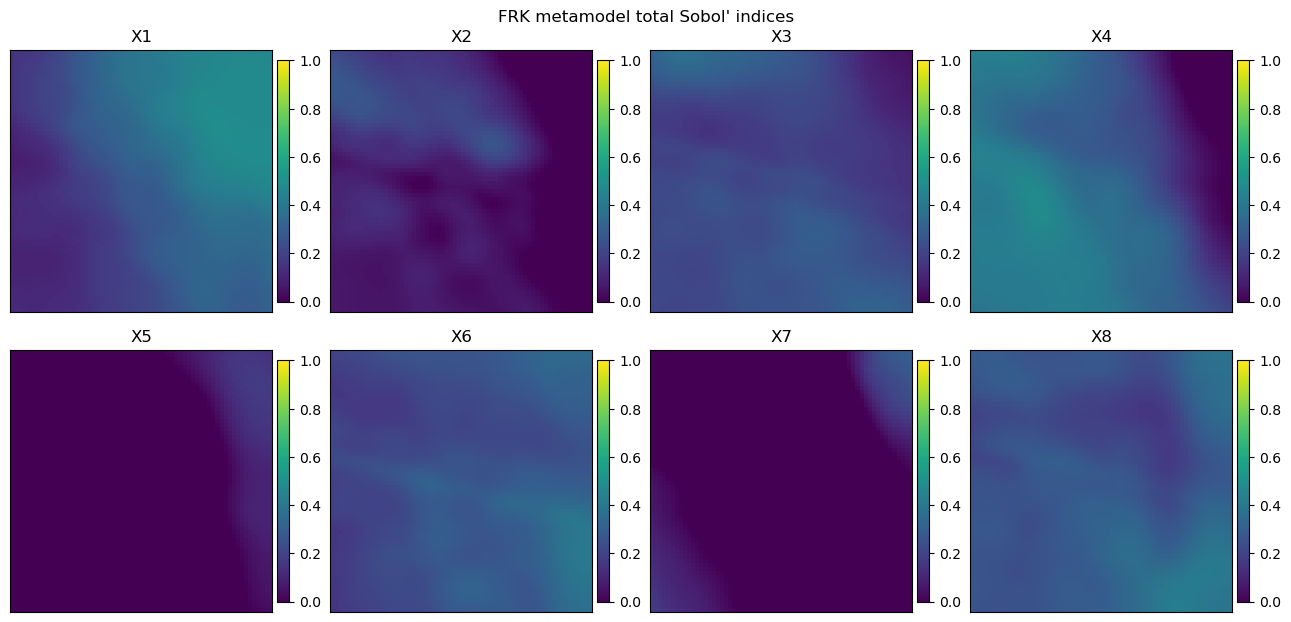

In [8]:
# nested_mc_sobol_maps currently calls wavelet-based predict_map_from_models.
# For FRK we call the same nested-MC logic by temporarily wrapping a predictor.

def _predict_frk(X):
    return predict_map_from_frk_models(models, X, mu_map=mu_map, basis=basis, order=order)

# Inline nested MC using the same logic as marrel_pipeline.sobol_metamodel, but with custom predictor.
import numpy as np

def nested_mc_sobol_maps_custom(predictor, *, d, low, high, n1, n2,
                               mc_outer_first, mc_inner_first,
                               mc_outer_total, mc_inner_total,
                               mc_varY, seed=7):
    rng = np.random.default_rng(seed)
    P = n1*n2

    Xv = low + (high - low) * rng.random((mc_varY, d))
    Yv = predictor(Xv).reshape(-1, P).astype(np.float64)
    varY = np.var(Yv, axis=0, ddof=1)
    varY = np.maximum(varY, 1e-12)

    S = np.zeros((d, P), dtype=np.float64)
    ST = np.zeros((d, P), dtype=np.float64)

    for i in range(d):
        Xi = low + (high - low) * rng.random((mc_outer_first, 1))
        cond_means = np.zeros((mc_outer_first, P), dtype=np.float64)
        for g in range(mc_outer_first):
            Xblock = low + (high - low) * rng.random((mc_inner_first, d))
            Xblock[:, i] = Xi[g, 0]
            Yblock = predictor(Xblock).reshape(-1, P).astype(np.float64)
            cond_means[g] = Yblock.mean(axis=0)
        S[i] = np.var(cond_means, axis=0, ddof=1) / varY

    for i in range(d):
        cols = [j for j in range(d) if j != i]
        Xminus = low + (high - low) * rng.random((mc_outer_total, d-1))
        cond_means = np.zeros((mc_outer_total, P), dtype=np.float64)
        for g in range(mc_outer_total):
            Xblock = low + (high - low) * rng.random((mc_inner_total, d))
            for jj, col in enumerate(cols):
                Xblock[:, col] = Xminus[g, jj]
            Yblock = predictor(Xblock).reshape(-1, P).astype(np.float64)
            cond_means[g] = Yblock.mean(axis=0)
        ST[i] = 1.0 - (np.var(cond_means, axis=0, ddof=1) / varY)

    return S.reshape(d, n1, n2), ST.reshape(d, n1, n2)

S_hat, ST_hat = nested_mc_sobol_maps_custom(_predict_frk, d=cfg.d, low=cfg.x_low, high=cfg.x_high,
                                           n1=cfg.grid_n1, n2=cfg.grid_n2,
                                           mc_outer_first=cfg.mc_outer_first, mc_inner_first=cfg.mc_inner_first,
                                           mc_outer_total=cfg.mc_outer_total, mc_inner_total=cfg.mc_inner_total,
                                           mc_varY=cfg.mc_varY, seed=7)

titles = [f"X{i+1}" for i in range(cfg.d)]
fig = plot_index_grid(ST_hat, titles, suptitle="FRK metamodel total Sobol' indices", ncols=4, vmin=0, vmax=0.5)
plt.show()


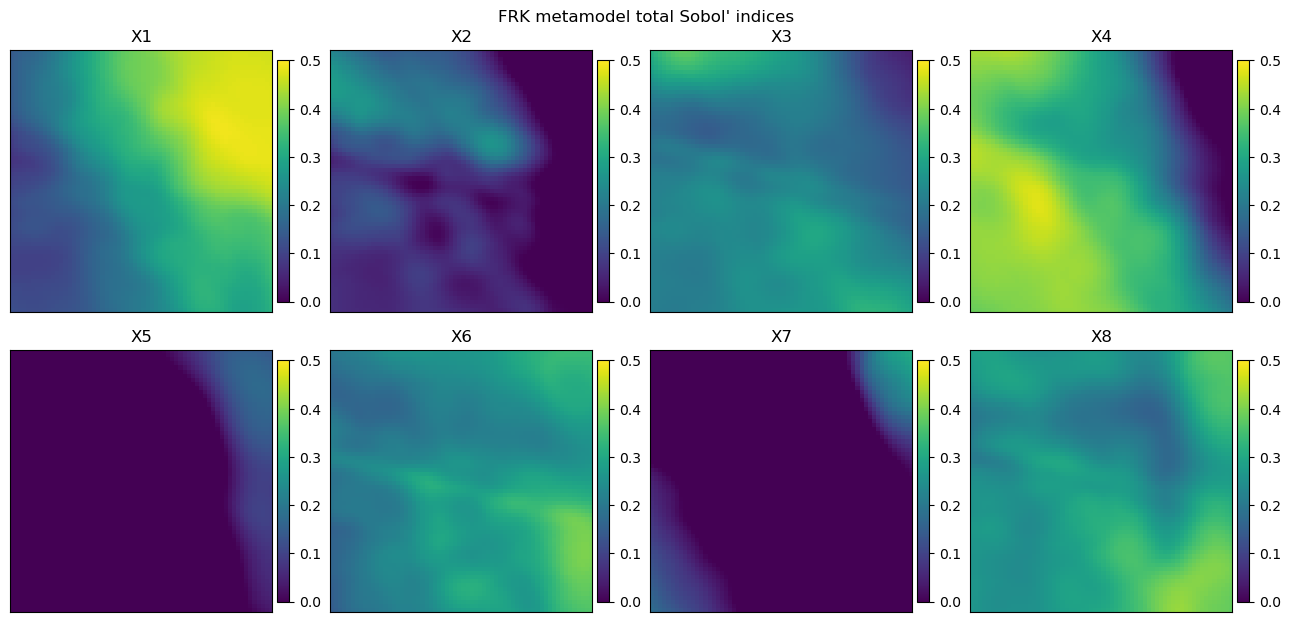

In [11]:

S_hat, ST_hat = nested_mc_sobol_maps_custom(_predict_frk, d=cfg.d, low=cfg.x_low, high=cfg.x_high,
                                           n1=cfg.grid_n1, n2=cfg.grid_n2,
                                           mc_outer_first=cfg.mc_outer_first, mc_inner_first=cfg.mc_inner_first,
                                           mc_outer_total=cfg.mc_outer_total, mc_inner_total=cfg.mc_inner_total,
                                           mc_varY=cfg.mc_varY, seed=7)

titles = [f"X{i+1}" for i in range(cfg.d)]
fig = plot_index_grid(ST_hat, titles, suptitle="FRK metamodel total Sobol' indices", ncols=4, vmin=0, vmax=0.5)
plt.show()

## rMAE vs exact first-order maps

In [9]:
rmae_vals = np.array([rmae(S_hat[i], S_exact[i]) for i in range(cfg.d)])
rmae_vals


array([0.53400212, 0.30066788, 0.41644638, 0.22169786, 1.1566684 ,
       0.18080526, 0.16272107, 0.35668674])

## Save results for comparison notebook

In [10]:
np.savez("results_frk.npz",
         S_exact=S_exact, ST_exact=ST_exact,
         S_hat=S_hat, ST_hat=ST_hat,
         mse=mse, q2=q2, rmae=rmae_vals,
         frk_r=basis.B.shape[1],
         frk_knots_per_level=np.array(cfg.frk_knots_per_level))
print("Wrote results_frk.npz")


Wrote results_frk.npz
